In [4]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno # Visualização de dados faltantes

# Estatística
import scipy
from scipy.stats import normaltest
from scipy.stats import chi2_contingency

# Engenharia de Atributos
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

- dataset sobre o RH de uma empresa onde os funcionários estão realizando um treinamento para melhorar suas habilidades em data science

In [5]:
df = pd.read_csv("dataset/aug_train.csv")

## Análise Exploratória de Dados

In [6]:
df.shape
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [7]:
len(df.columns)

14

In [8]:
df.describe(include=object) # Variáveis categóricas

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,19158,14650,19158,18772,18698,16345,19093,13220,13018,18735
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,4355,13221,13792,13817,11598,14492,3286,3083,9817,8040


In [9]:
df.describe().drop(columns = ['enrollee_id', 'target']) # Variáveis quantitativas

,city_development_index,training_hours
count,19158.000000,19158.000000
mean,0.828848,65.366896
std,0.123362,60.058462
min,0.448000,1.000000
25%,0.740000,23.000000
50%,0.903000,47.000000
75%,0.920000,88.000000
max,0.949000,336.000000


- O indice de desenvolvimento da cidade em média é de 0.828 e medianda 0.903000 que significa que a cidade está em um nível de desenvolvimento alto.
- O desvio padrão (std) de 0.12 significa que nossos dados estão bem distribuídos.
- Em horas de treinamento a média é de 65,4 horas e a mediana de 47 horas, com um valor maximo de 336 horas. Isso significa que 50% dos nossos alunos não passam de 47 horas de treinamento mas há candidatos com muitas horas de treinamento.

In [10]:
# variaveis categoricas
list(df.columns.values)[3:12]

['gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

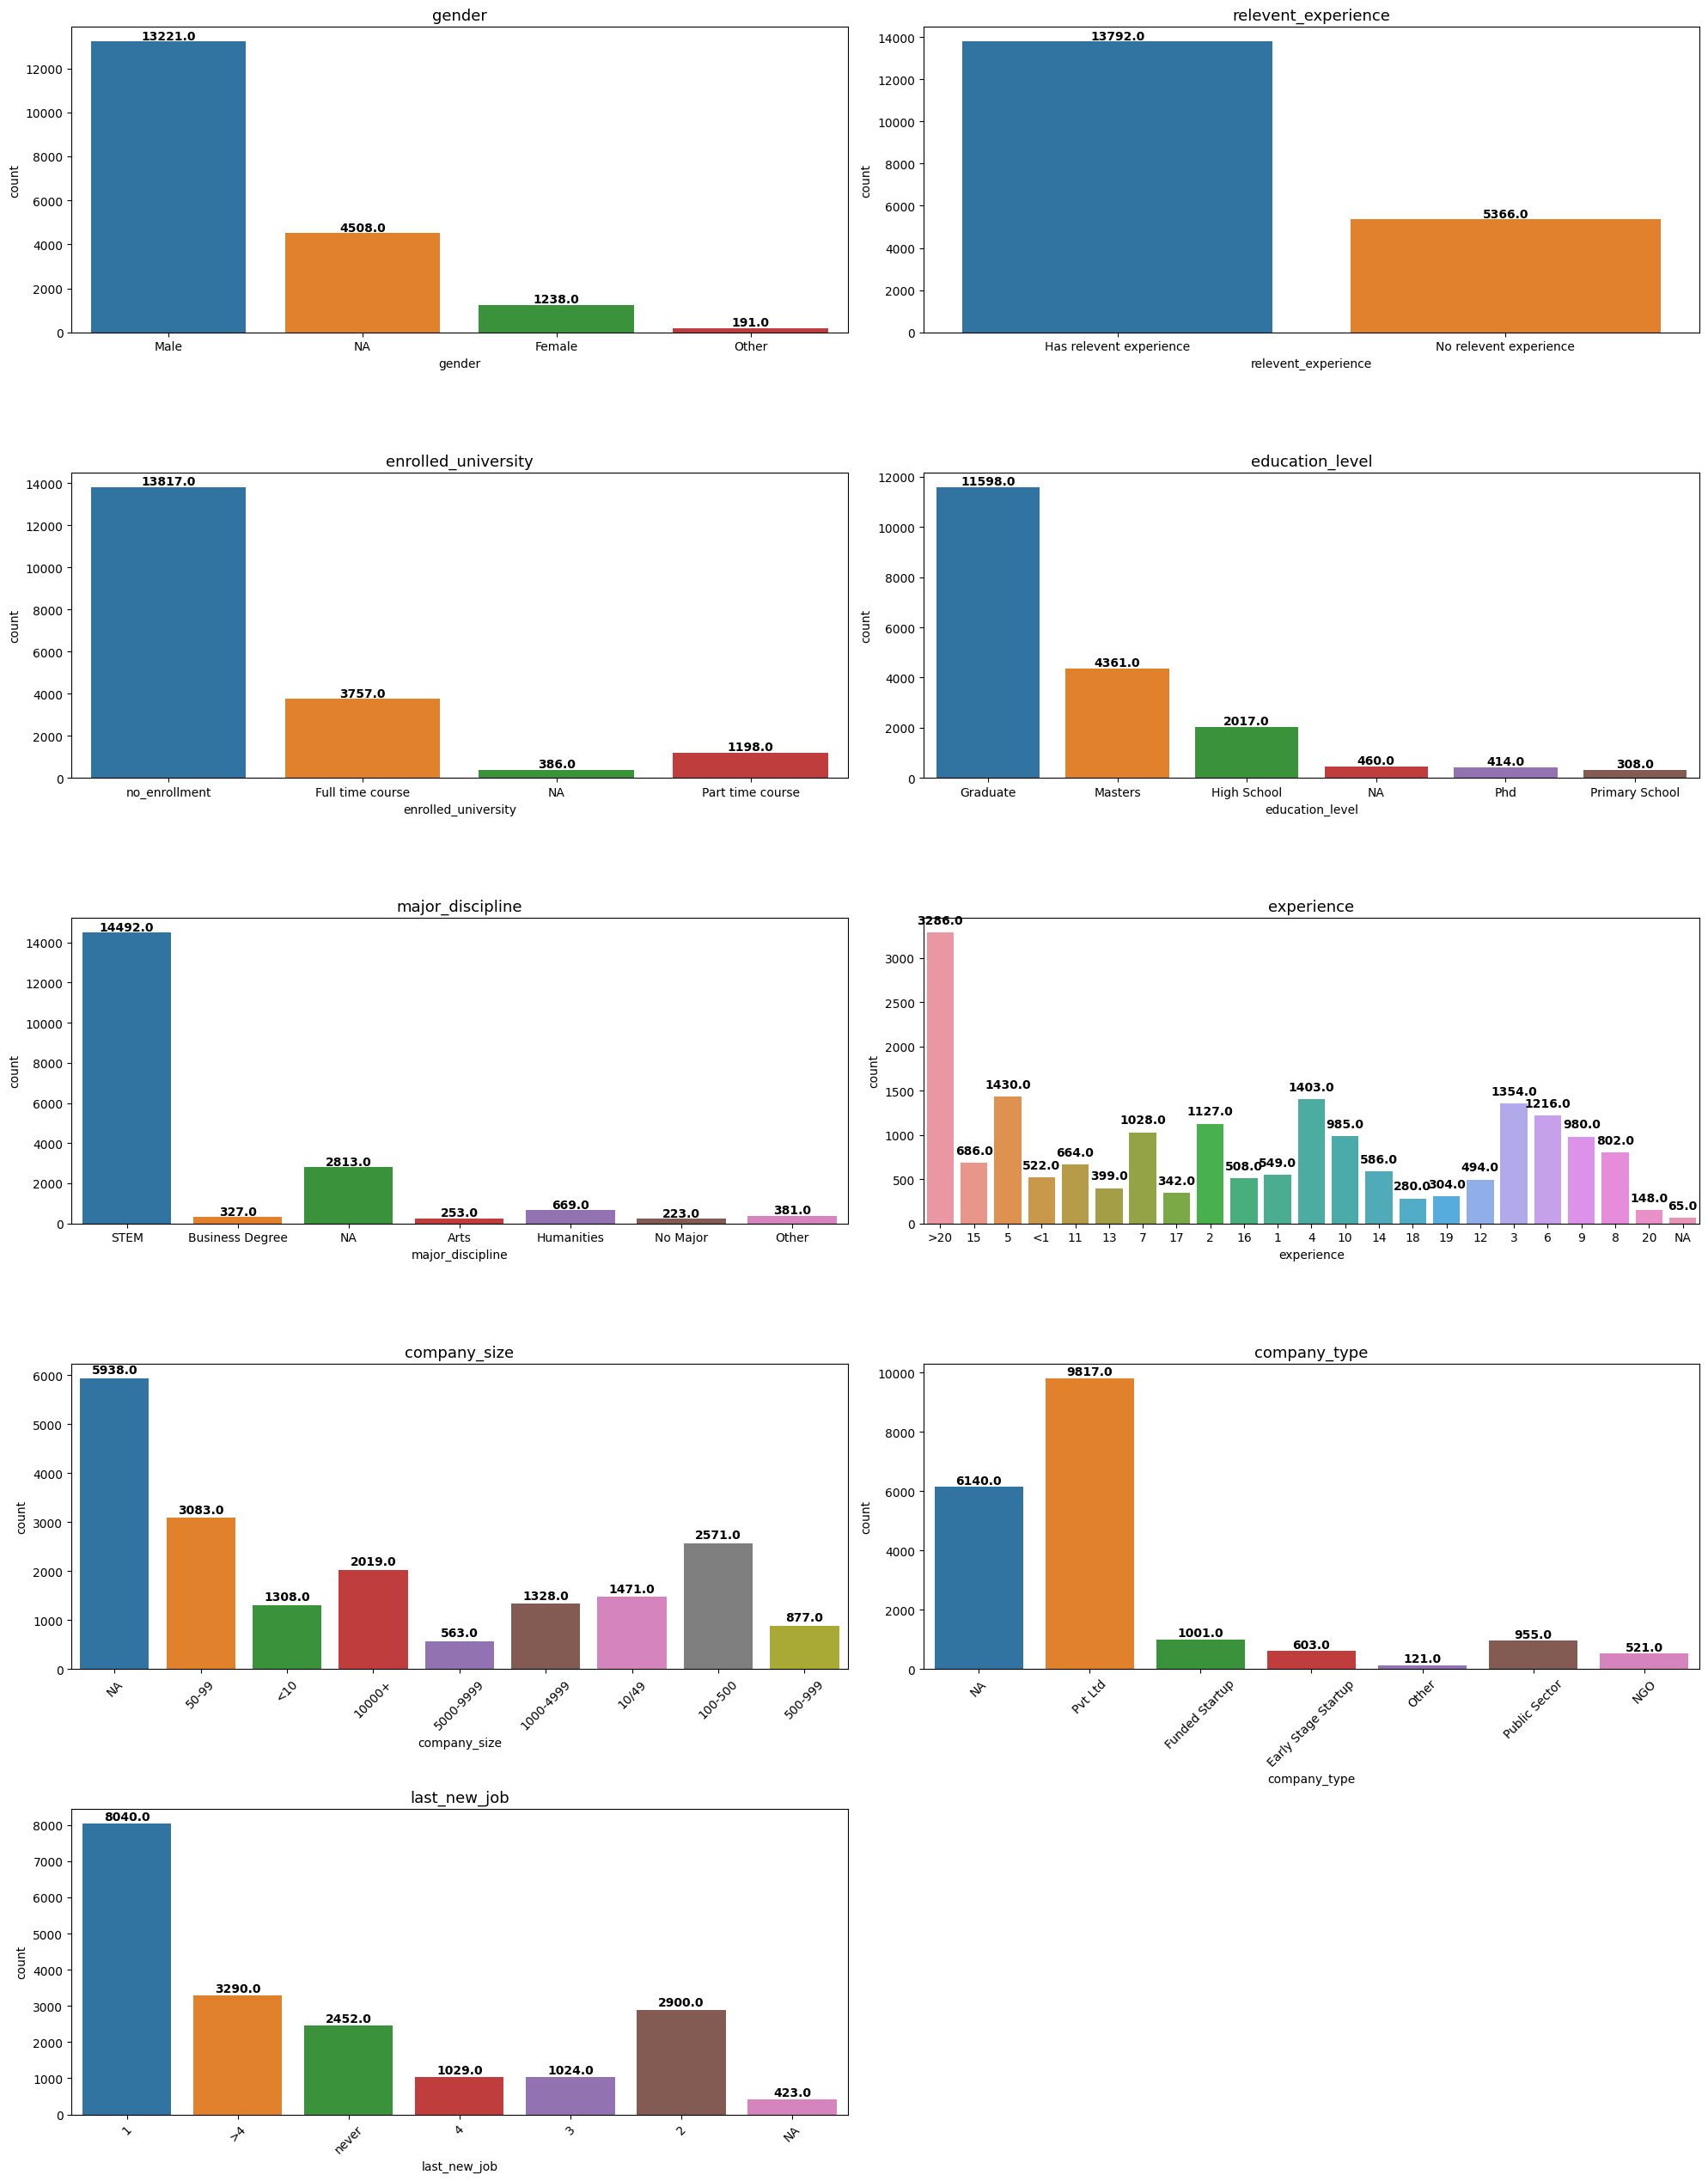

In [11]:
# plotando variaveis categoricas
plt.figure(figsize=(20, 30))
columns_list = list(df.columns.values)[3:12]


a = 0
for coluna in columns_list:
    a += 1
    plt.subplot(6, 2, a)
    ax = sns.countplot(data=df.fillna("NA"), x=coluna)
    plt.title(coluna, fontsize=13)
    # inserindo num acima da barra
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height()}",
            (p.get_x() + 0.4, # X = 0.4 para centralizar
             p.get_height()+100), # Distancia do topo da barra e do numero
            ha="center", # Centralizado
            color="black", # Cor do texto
            fontsize=10, # Tamanho da fonte
            fontweight="bold", # Negrito
            rotation=0 # Rotacao do texto
            )
    if a >= 7:
        plt.xticks(rotation=45)

# layout
plt.tight_layout(h_pad=2)  # ajusta o espaçamento entre os gráficos


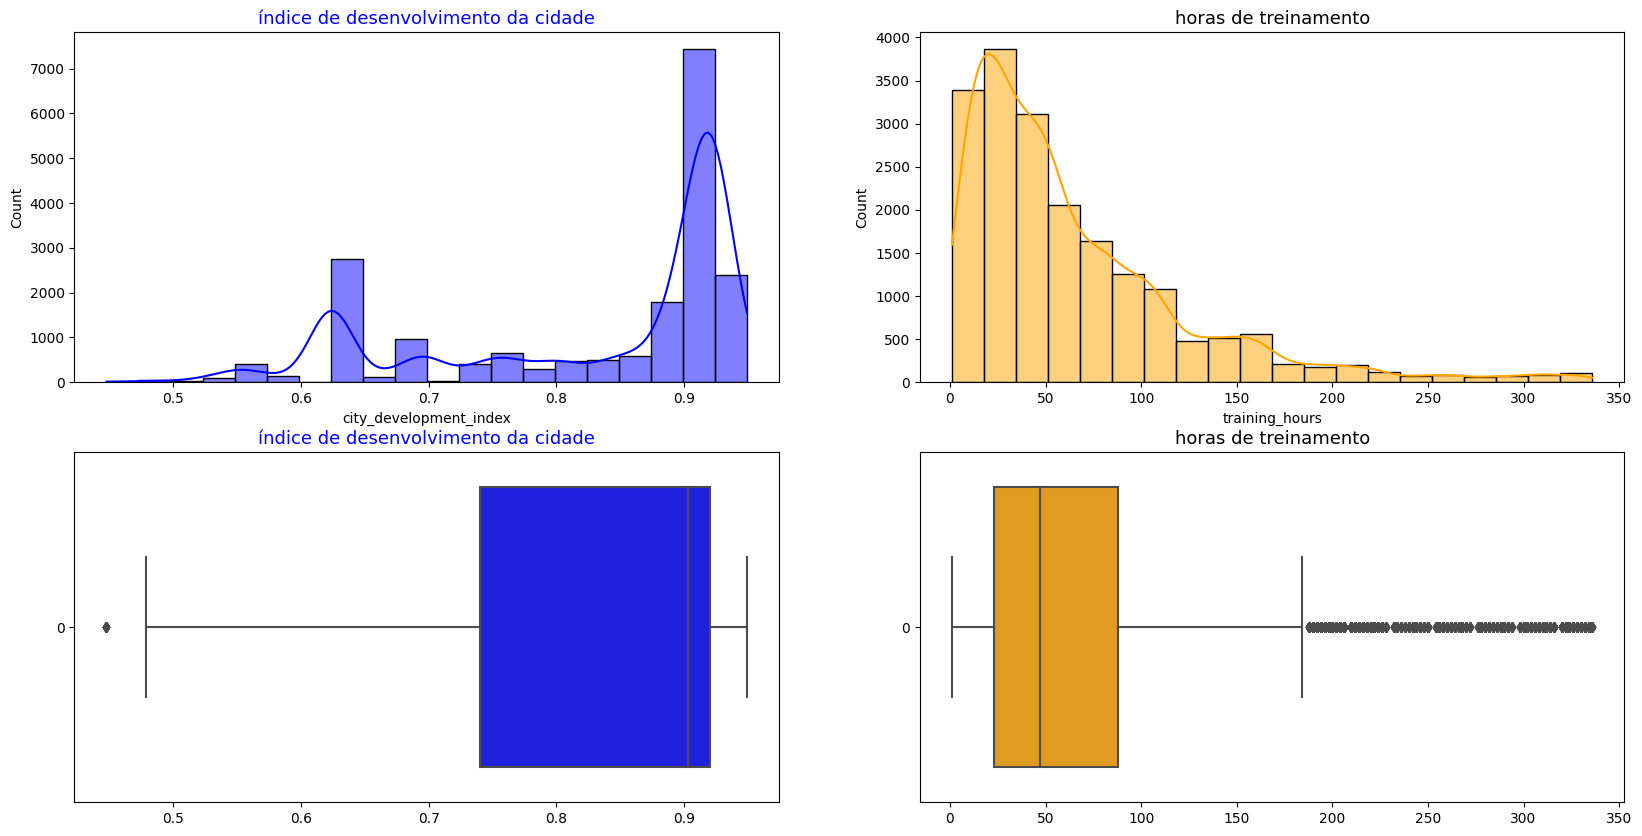

In [12]:
# variaveis quantitativas
plt.figure(figsize=(20, 10))

plt.subplot(221) # 2 linhas, 2 colunas, 1º gráfico
# plt.color_palette("hls", 8)
sns.histplot(df['city_development_index'], kde=True, color='blue', bins=20) # stat='density' para plotar a densidade
plt.title("índice de desenvolvimento da cidade", fontsize=13, color = 'blue')

plt.subplot(222) # 2 linhas, 2 colunas, 2º gráfico
sns.histplot(df['training_hours'], kde=True, color='orange', bins=20) # kde = curva de densidade
plt.title("horas de treinamento", fontsize=13)

plt.subplot(223) # 2 linhas, 2 colunas, 3º gráfico
sns.boxplot(df['city_development_index'], color='blue', orient='h')
plt.title("índice de desenvolvimento da cidade", fontsize=13, color = 'blue')

plt.subplot(224) # 2 linhas, 2 colunas, 4º gráfico
sns.boxplot(df['training_hours'], color='orange', orient='h')
plt.title("horas de treinamento", fontsize=13)

plt.show()

- na variavel horas de treinamento temos uma distribuição assimetrica a direita, indicando que a media é maior que a mediana, ou seja, temos uma cauda longa a direita.	
- na variavel indice de desenvolvimento da cidade temos uma distribuição assimetrica a esquerda indicando que a media é menor que a mediana, ou seja, temos uma cauda longa a esquerda.

## Teste de normalidade das variáveis

In [13]:
var_test = ['training_hours', 'city_development_index']

for i in var_test:
    stats, pval = normaltest(df[i])
    if pval < 0.05:
        print(f'A variável _{i}_ não segue uma distribuição normal')
    else:
        print(f'A variável _{i}_ segue uma distribuição normal')

A variável _training_hours_ não segue uma distribuição normal
A variável _city_development_index_ não segue uma distribuição normal


- os dados não seguem uma distribuição normal por isso aplicarei uma analise não paramétrica
- Dados de horas de treinamento estão agrupados a direita, o que pode ser explicado por um elevado animo ao se iniciar o treinamento mas nem todos conseguem termina-lo

<h2> Correlação entre os dados </h2>

Analisarei a correlaão entre as variáveis numéricas e a variável alvo

In [14]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [15]:
df_numerical = df.copy()
df_numerical.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [16]:
df_numerical["experience"].value_counts()

>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
Name: experience, dtype: int64

In [17]:
# Convertendo a variável experience para numérica
df_numerical["experience"] = np.where(df_numerical["experience"] == "<1", 1, df_numerical["experience"]) # substituindo "<1" por 1
df_numerical["experience"] = np.where(df_numerical["experience"] == ">20", 21, df_numerical["experience"])
df_numerical["experience"] = df_numerical["experience"].astype(float)

In [18]:
df_numerical["last_new_job"].value_counts()

1        8040
>4       3290
2        2900
never    2452
4        1029
3        1024
Name: last_new_job, dtype: int64

In [19]:
df_numerical["last_new_job"] = np.where(df_numerical["last_new_job"] == "never", 0, df_numerical["last_new_job"])
df_numerical["last_new_job"] = np.where(df_numerical["last_new_job"] == ">4", 5, df_numerical["last_new_job"])
df_numerical["last_new_job"] = df_numerical["last_new_job"].astype(float)

In [20]:
df_numerical.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,21.0,NaN,NaN,1.0,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,5.0,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,0.0,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,1.0,NaN,Pvt Ltd,0.0,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,21.0,50-99,Funded Startup,4.0,8,0.0


In [21]:
df_numerical.drop("enrollee_id", axis = 1).corr("spearman") # correlação de spearman desconsiderando a variável enrollee_id e objects

,city_development_index,experience,last_new_job,training_hours,target
city_development_index,1.000000,0.300997,0.182698,0.007491,-0.279165
experience,0.300997,1.000000,0.473284,0.003569,-0.183721
last_new_job,0.182698,0.473284,1.000000,0.002959,-0.082045
training_hours,0.007491,0.003569,0.002959,1.000000,-0.014126
target,-0.279165,-0.183721,-0.082045,-0.014126,1.000000


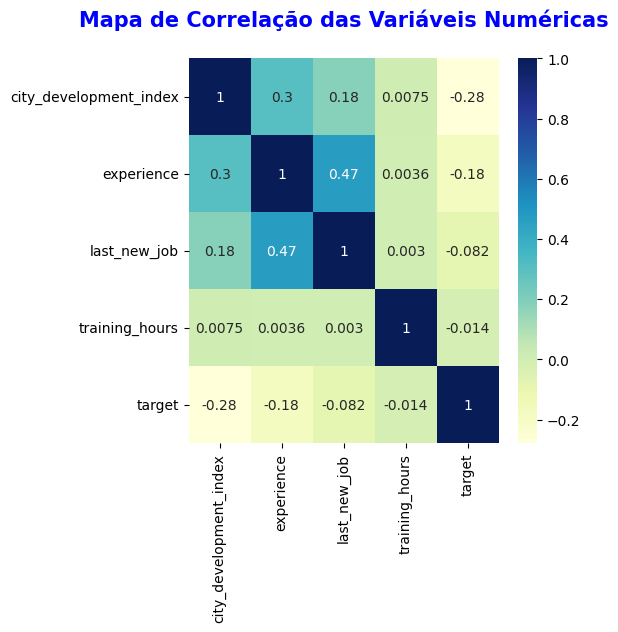

In [22]:
# Heatmap
plt.figure(figsize = (5,5))
sns.heatmap(df_numerical.drop("enrollee_id", axis = 1).corr("spearman"), annot = True, cmap = "YlGnBu")
plt.title("Mapa de Correlação das Variáveis Numéricas\n", fontsize = 15, fontweight = "bold", color = "blue", loc = "center")
plt.show()

### Weight of Evidence (WOE) e Information Value (IV)

Este conjunto de dados contém mais dados com tipo categórico do que tipo numérico. 
Usarei recursos categóricos nominais para WOE (peso da evidencia) e IV (valor da informacao).


Interpretamos o resultado de IV assim:

    Information Value, Poder de Previsão
    
    < 0.02, não deve ser usado para previsão
    0.02 - 0.1, preditor fraco
    0.1 - 0.3, preditor médio
    0.3 - 0.5, preditor forte
    > 0.5, preditor muito forte

In [23]:
for i in df.drop(columns = ['target',
                            'enrollee_id',
                            'city',
                            'city_development_index',
                            'training_hours',
                            'experience',
                            'last_new_job',
                            'company_size']).columns: # variáveis categóricas
    
    df_woe_iv = (pd.crosstab(df[i], df['target'], normalize = 'columns') # crosstab normalizada
                 .assign(woe = lambda dfx: np.log(dfx[1] / dfx[0])) # calculando woe
                 .assign(iv = lambda dfx: np.sum(dfx['woe'] * (dfx[1]-dfx[0])))) # calculando iv
    
    print(df_woe_iv,'\n------------------------------------------------------------')

target      0.0       1.0       woe        iv
gender                                       
Female  0.08098  0.096222  0.172452  0.003337
Male    0.90650  0.889020 -0.019471  0.003337
Other   0.01252  0.014758  0.164458  0.003337 
------------------------------------------------------------
target                        0.0       1.0       woe        iv
relevent_experience                                            
Has relevent experience  0.753147  0.619845 -0.194790  0.083523
No relevent experience   0.246853  0.380155  0.431784  0.083523 
------------------------------------------------------------
target                    0.0       1.0       woe        iv
enrolled_university                                        
Full time course     0.164754  0.307477  0.623947  0.118886
Part time course     0.063465  0.064890  0.022210  0.118886
no_enrollment        0.771781  0.627632 -0.206746  0.118886 
------------------------------------------------------------
target                0.0   

<Figure size 2000x2000 with 0 Axes>

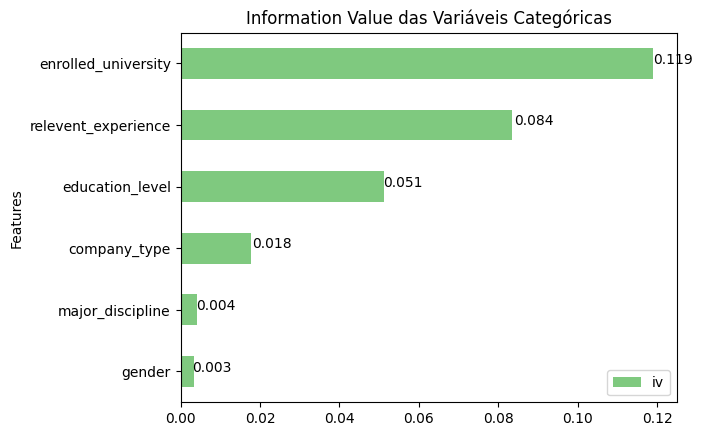

In [24]:
# Plot do Information Value
# Variáveis categóricas
columns_cat = df.drop(columns = ['target',
                                 'enrollee_id',
                                 'city', 
                                 'city_development_index',
                                 'training_hours',
                                 'experience',
                                 'last_new_job',
                                 'company_size']).columns # deletando as variáveis numéricas e target para plotar o IV

# Lista para o IV
iv = []

# Loop
for i in columns_cat:
    df_woe_iv = (pd.crosstab(df[i], df['target'], normalize = 'columns')
                 .assign(woe = lambda dfx: np.log(dfx[1] / dfx[0]))
                 .assign(iv = lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
    iv.append(df_woe_iv['iv'][0])

# Dataframe
df_iv = pd.DataFrame({'Features':columns_cat,'iv':iv}).set_index('Features').sort_values(by = 'iv')

# Plot
# Figura
plt.figure(figsize = (20,20))
df_iv.plot(kind = 'barh', title = 'Information Value das Variáveis Categóricas', colormap = "Accent")
for index, value in enumerate(list(round(df_iv["iv"],3))):
    plt.text((value), index, str(value))
plt.legend(loc  = "lower right")

plt.show()

* No gráfico acima, podemos ver a ordem dos recursos com base em seu poder preditivo em relação ao alvo.
* Com base em seu valor IV, `enrolled_university` é um preditor médio, `relevent_experience` e `education_level` são preditores fracos e os outros são inúteis para a previsão.

## Valores Ausentes e duplicados

In [27]:
# Valores ausentes por coluna
null_df = df.isna().sum().reset_index()

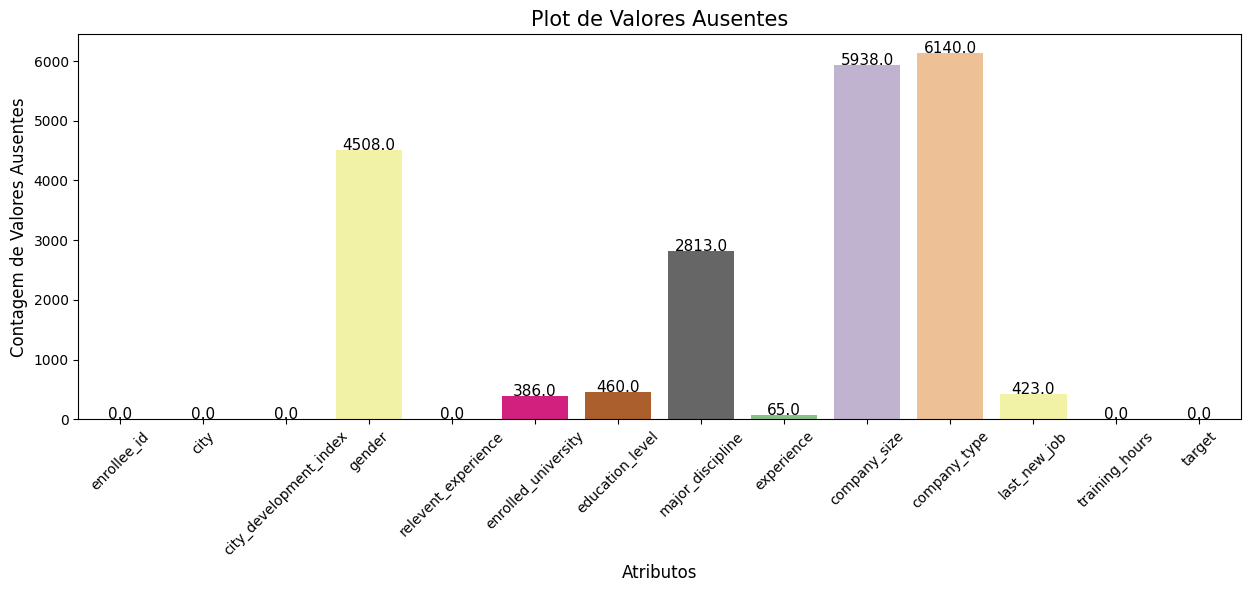

In [34]:
ax = plt.figure(figsize = (15,5))

# plotando o gráfico null_df para cada coluna
ax = sns.barplot(x = null_df['index'], y = null_df[0], palette = "Accent")
plt.xlabel('Atributos', fontsize = 12)
plt.ylabel('Contagem de Valores Ausentes', fontsize = 12)
plt.xticks(rotation = 45)
plt.title("Plot de Valores Ausentes", fontsize = 15)

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, (p.get_height())), ha = 'center', color = 'black', size = 11)

plt.show()

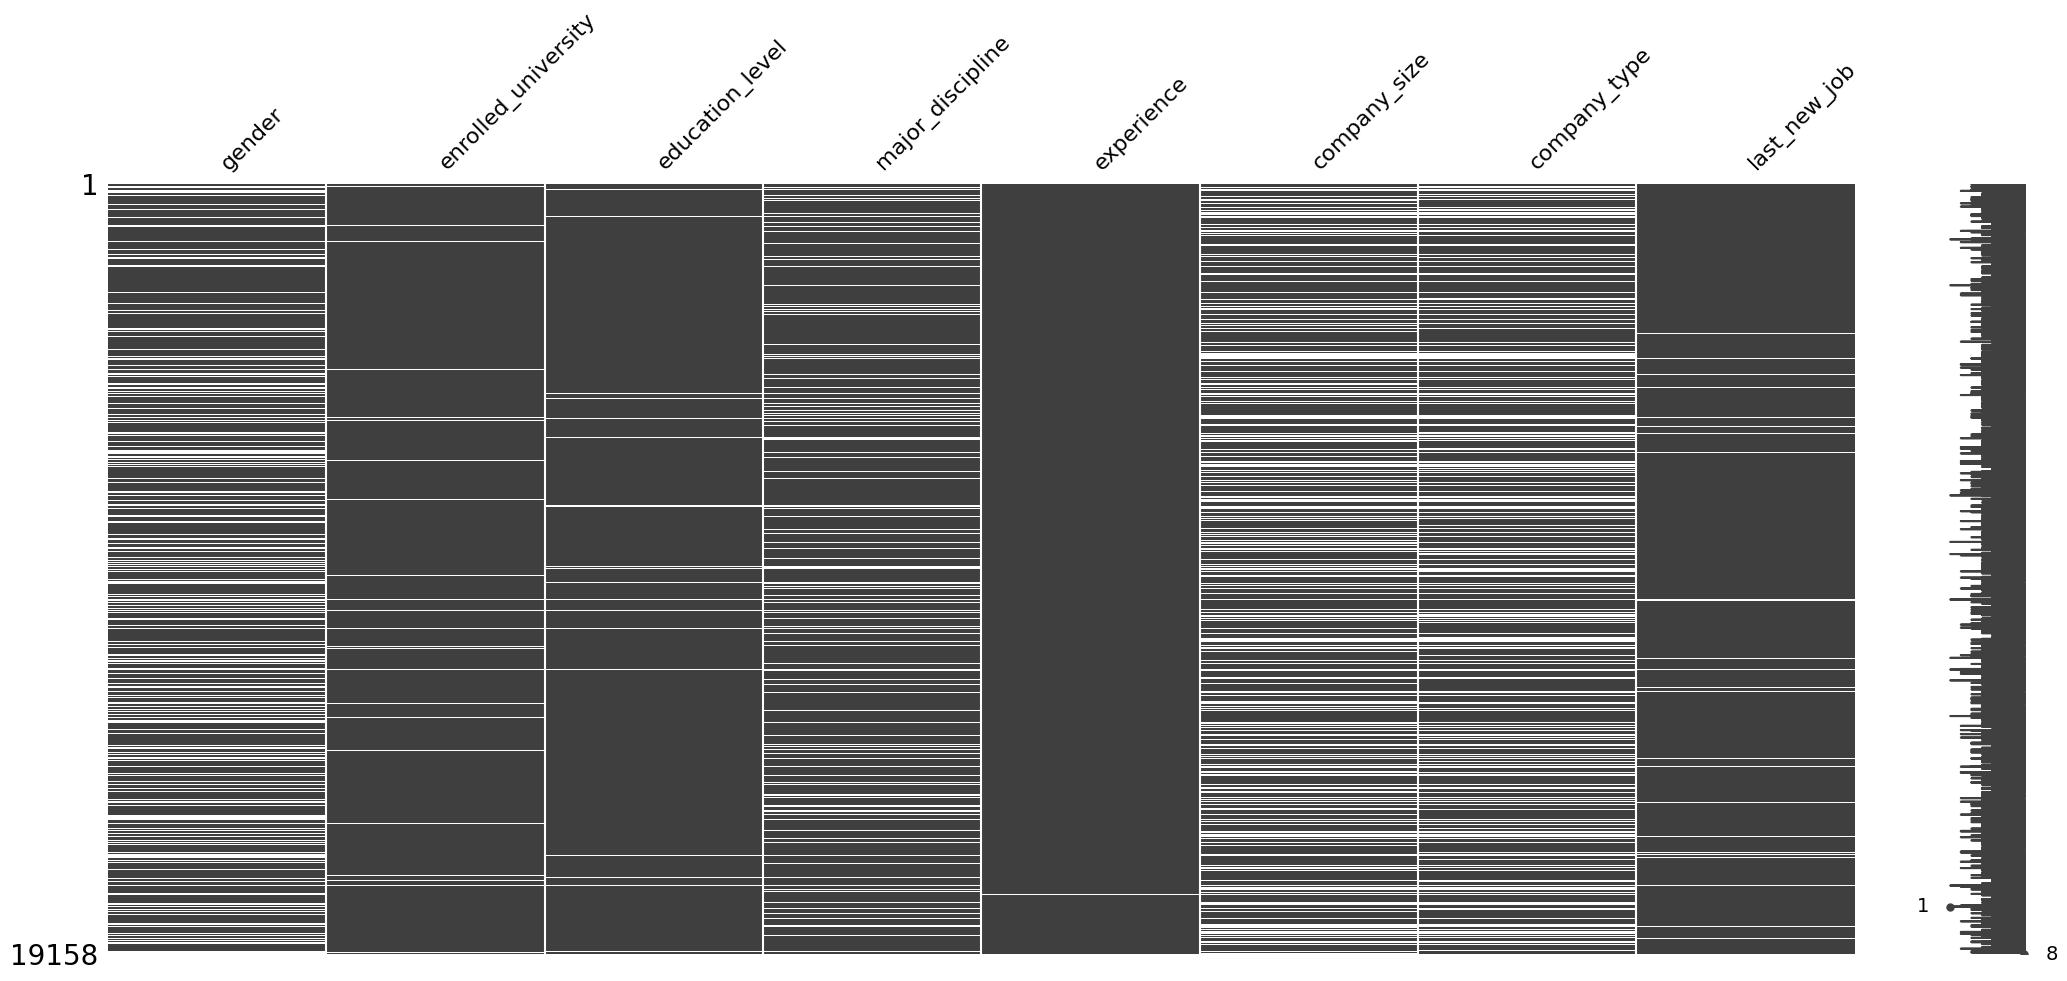

In [33]:
# Mapa de valores ausentes por coluna
df_nan = pd.DataFrame(df.isna().sum())

# Plot - Mapa de Valores Ausentes
if df.isna().any(axis = None):
    missingno.matrix(df[df_nan[df_nan[0]>0].index])
    plt.show()

os valores ausentes não apresentam um padrão, não há uma variável que apresente valores ausentes em todas as linhas.

In [35]:
# checando valores duplicados
df['enrollee_id'].duplicated().sum()

0

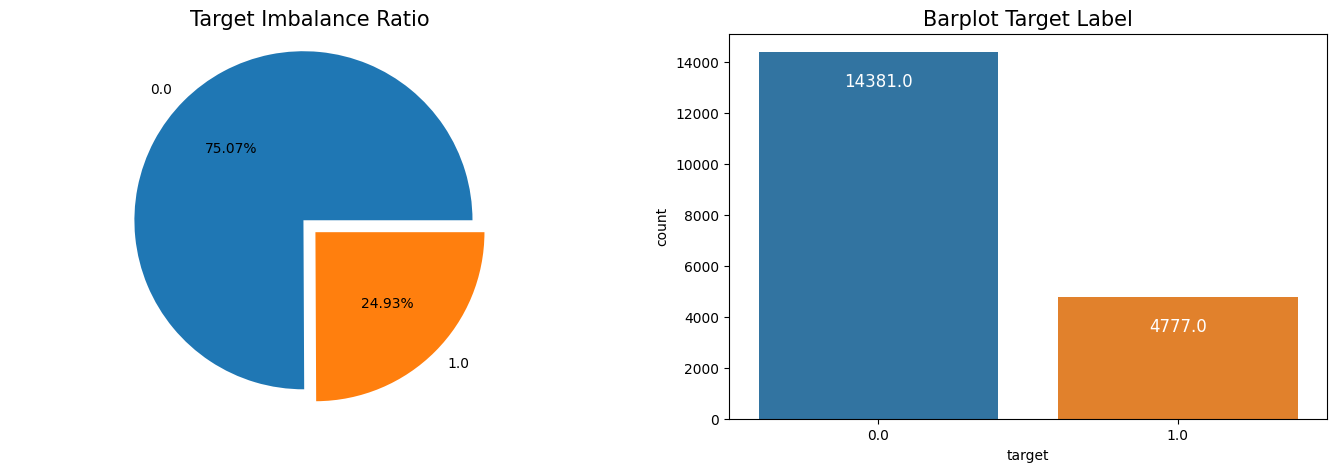

In [39]:
# Figura
plt.figure(figsize = (17,(100)/20))

plt.subplot(121)

plt.pie(round(df['target'].value_counts() / len(df) * 100, 2),
        labels = list(df['target'].value_counts().index),
        autopct = "%.2f%%",
        explode = (0,0.1))

plt.axis("equal")
plt.title("Target Imbalance Ratio", size = 15)

plt.subplot(122)
ax = sns.countplot(data = df, x = 'target')
plt.title("Barplot Target Label", fontsize = 15)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', 
                (p.get_x()+0.4, 
                 p.get_height()), 
                ha = 'center', 
                va = 'top', 
                color = 'white', 
                size = 12)

## Limpeza e processamento dos dados

### Tratando valores ausentes

In [40]:
df.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [41]:
colunas_manter = ['city_development_index', 
                  'experience', 
                  'enrolled_university', 
                  'relevent_experience', 
                  'education_level',
                  'company_type',
                  'major_discipline',
                  'target']

In [43]:
new_df = df[colunas_manter]
new_df.head()

,city_development_index,experience,enrolled_university,relevent_experience,education_level,company_type,major_discipline,target
0,0.920,>20,no_enrollment,Has relevent experience,Graduate,NaN,STEM,1.0
1,0.776,15,no_enrollment,No relevent experience,Graduate,Pvt Ltd,STEM,0.0
2,0.624,5,Full time course,No relevent experience,Graduate,NaN,STEM,0.0
3,0.789,<1,NaN,No relevent experience,Graduate,Pvt Ltd,Business Degree,1.0
4,0.767,>20,no_enrollment,Has relevent experience,Masters,Funded Startup,STEM,0.0


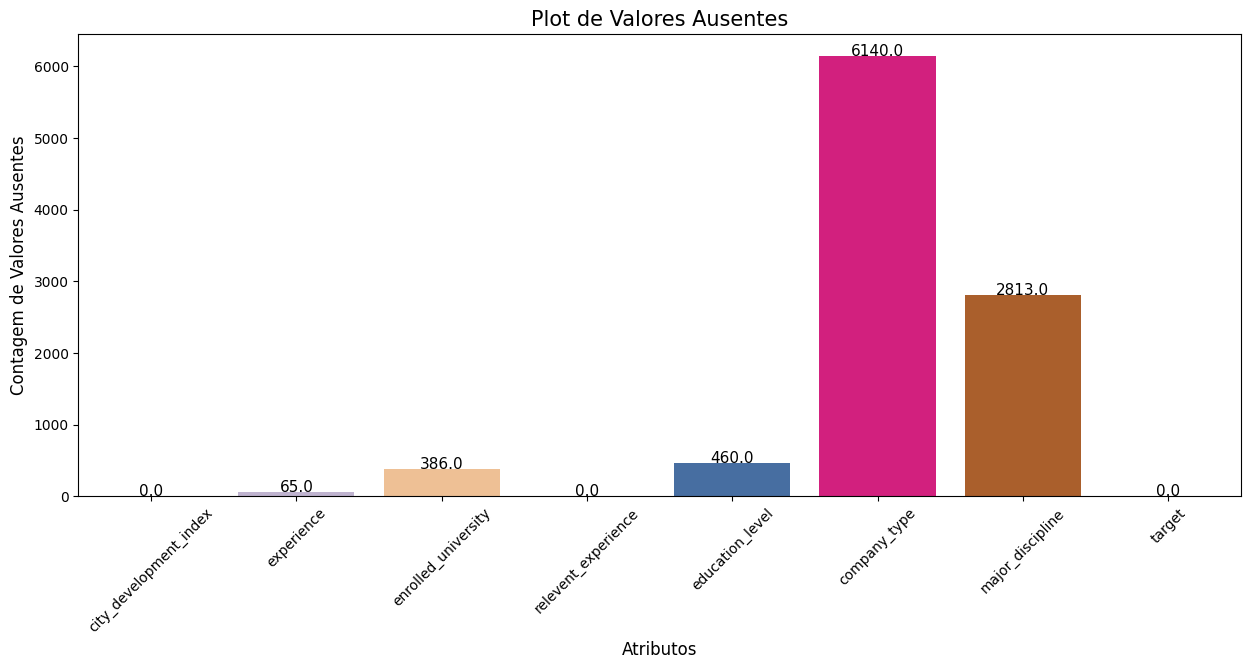

In [46]:
null_df = new_df.isna().sum().reset_index()

ax = plt.figure(figsize = (15,6))
ax = sns.barplot(x = null_df['index'], y = null_df[0], palette = "Accent")
plt.xlabel('Atributos', fontsize = 12)
plt.ylabel('Contagem de Valores Ausentes', fontsize = 12)
plt.xticks(rotation = 45)
plt.title("Plot de Valores Ausentes", fontsize = 15)

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, (p.get_height())), ha = 'center', color = 'black', size = 11)

plt.show()

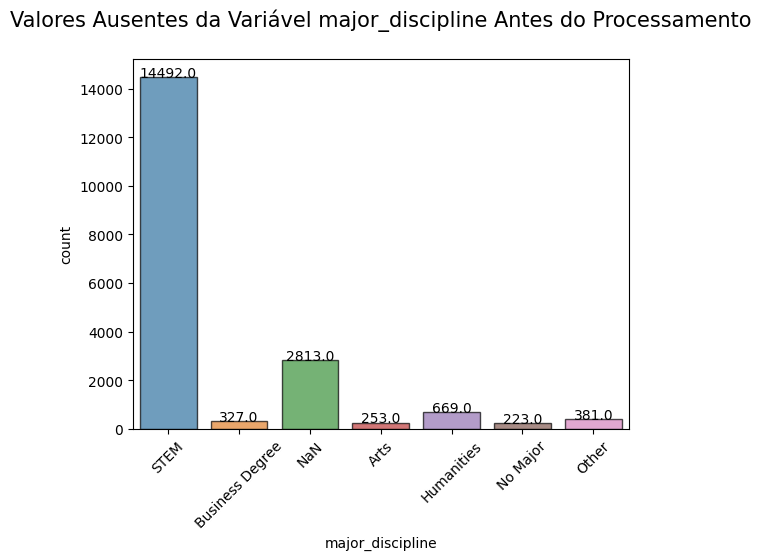

In [47]:
# Valores Ausentes da Variável major_discipline Antes do Processamento
sns.countplot(data = new_df.fillna('NaN'), x = 'major_discipline', alpha = 0.7, edgecolor = 'black')
plt.xticks(rotation = 45)
bound = ax.get_xbound()
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 10)
plt.title("Valores Ausentes da Variável major_discipline Antes do Processamento\n", fontsize = 15)
plt.show()

In [48]:
# Relação entre major_discipline x education_level
print('\nTotal de Valores Ausentes na Variável major_discipline:', new_df['major_discipline'].isna().sum())
print('\nProporção de Valores Ausentes na Variável education_level:')
new_df[new_df['major_discipline'].isna()]['education_level'].value_counts(dropna = False)


Total de Valores Ausentes na Variável major_discipline: 2813

Proporção de Valores Ausentes na Variável education_level:


High School       2017
NaN                460
Primary School     308
Graduate            22
Masters              6
Name: education_level, dtype: int64

Dentre os registros com valores ausentes, vemos a proporção na variável education_level.

Preencheremos os valores NA da variável `major_discipline` com `Non Degree`.

In [50]:
# Cria o índice
nan_index = (new_df[(new_df['major_discipline'].isna()) & ((new_df['education_level']=='High School') | (new_df['education_level'].isna()) | (new_df['education_level']=='Primary School'))]).index

len(nan_index)

2785

In [51]:
# Imputação do valor ausente
new_df['major_discipline'][nan_index] = 'Non Degree'

In [52]:
print('Total de Valores Ausentes na Variável major_discipline:', new_df['major_discipline'].isna().sum())
new_df['major_discipline'].value_counts(dropna = False)

Total de Valores Ausentes na Variável major_discipline: 28


STEM               14492
Non Degree          2785
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
NaN                   28
Name: major_discipline, dtype: int64

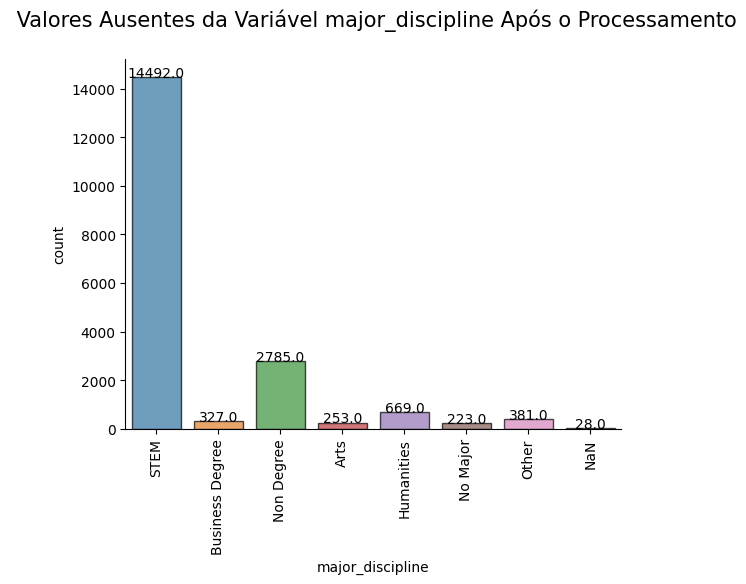

In [56]:
# Valores Ausentes da Variável major_discipline Após o Processamento
sns.countplot(data = new_df.fillna('NaN'), x = 'major_discipline', alpha = 0.7, edgecolor = 'black')
sns.despine()
plt.xticks(rotation=90)
bound=ax.get_xbound()
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 10)
plt.title(" Valores Ausentes da Variável major_discipline Após o Processamento\n", fontsize = 15)
plt.show()

In [57]:
new_df[new_df['major_discipline'].isna()]  = 'Other'

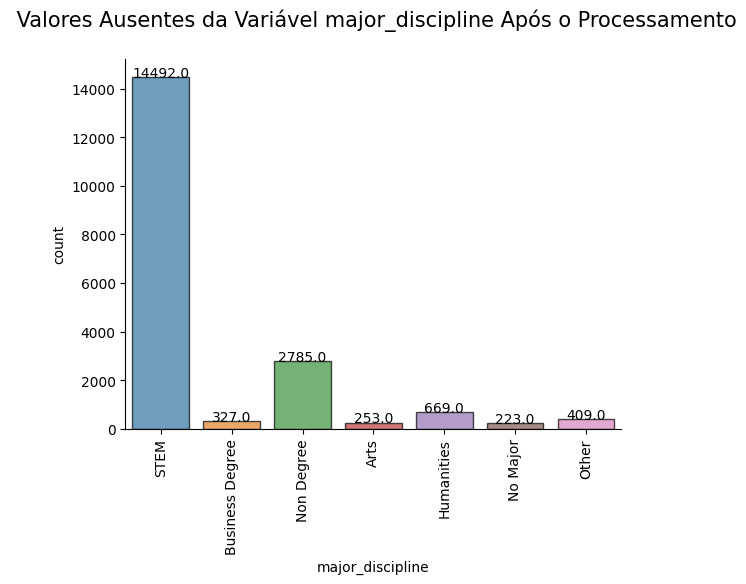

In [59]:
# Valores Ausentes da Variável major_discipline Após o Processamento
sns.countplot(data = new_df.fillna('NaN'), x = 'major_discipline', alpha = 0.7, edgecolor = 'black')
sns.despine()
plt.xticks(rotation=90)
bound=ax.get_xbound()
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 10)
plt.title(" Valores Ausentes da Variável major_discipline Após o Processamento\n", fontsize = 15)
plt.show()

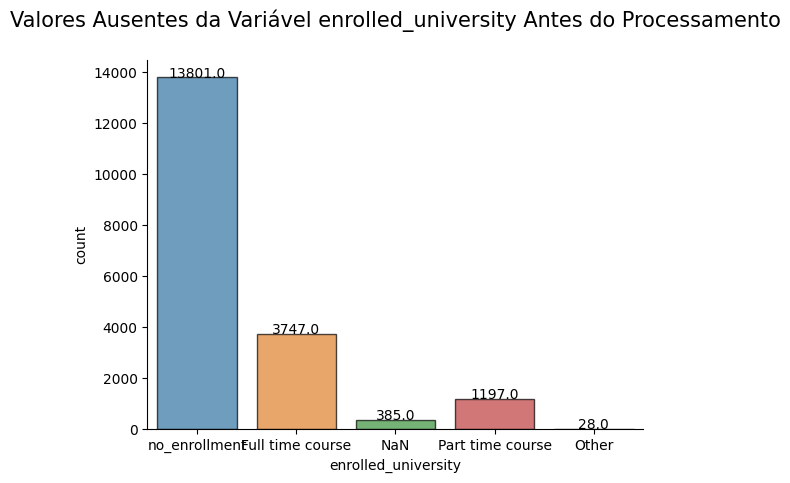

In [60]:
# Plot
sns.countplot(data = new_df.fillna('NaN'), x = 'enrolled_university', alpha = 0.7, edgecolor = 'black')
sns.despine()
plt.xticks()
bound=ax.get_xbound()
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 10)
plt.title("Valores Ausentes da Variável enrolled_university Antes do Processamento\n", fontsize = 15)
plt.show()

In [61]:
print('\nTotal de Valores Ausentes na Variável enrolled_university:', new_df['enrolled_university'].isna().sum())
print('\nProporção de Valores Ausentes na Variável education_level:')
new_df[new_df['enrolled_university'].isna()]['education_level'].value_counts(dropna = False)


Total de Valores Ausentes na Variável enrolled_university: 385

Proporção de Valores Ausentes na Variável education_level:


Graduate          170
NaN               100
Masters            53
High School        47
Primary School      9
Phd                 6
Name: education_level, dtype: int64

Candidatos com `Primary School` como `education_level` não estão qualificados para ingressar na universidade. Portanto, preencheremos valores `NaN` em `education_level` para `Primary Grad`.

In [63]:
nan_index = (new_df[(new_df['enrolled_university'].isna()) & (new_df['education_level']=='Primary School')]).index

len(nan_index)

9

In [64]:
new_df['enrolled_university'][nan_index] = 'Primary Grad'

print('Total de Valores Ausentes:', new_df['enrolled_university'].isna().sum())
new_df[new_df['enrolled_university'].isna()]['education_level'].value_counts(dropna = False)

Total de Valores Ausentes: 376


Graduate       170
NaN            100
Masters         53
High School     47
Phd              6
Name: education_level, dtype: int64

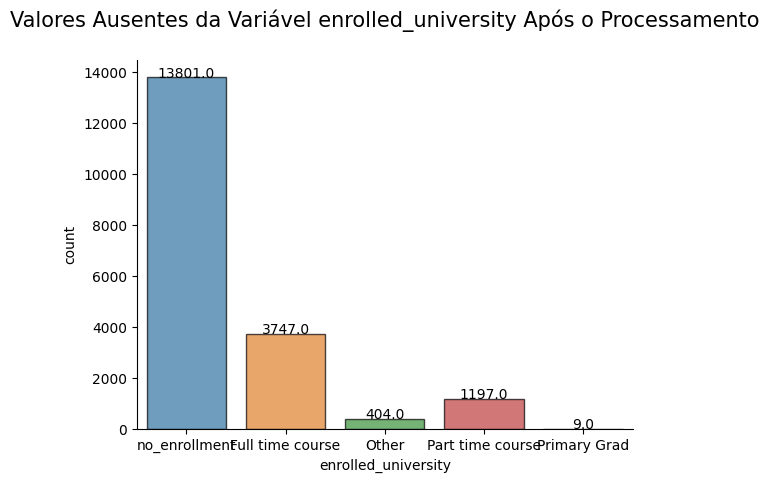

In [65]:
nan_index = new_df[(new_df['enrolled_university'].isna())].index
new_df['enrolled_university'][nan_index] = 'Other'

# Plot
sns.countplot(data = new_df.fillna('NaN'), x = 'enrolled_university', alpha = 0.7, edgecolor = 'black')
sns.despine()
plt.xticks()
bound=ax.get_xbound()
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 10)
plt.title("Valores Ausentes da Variável enrolled_university Após o Processamento\n", fontsize = 15)
plt.show()

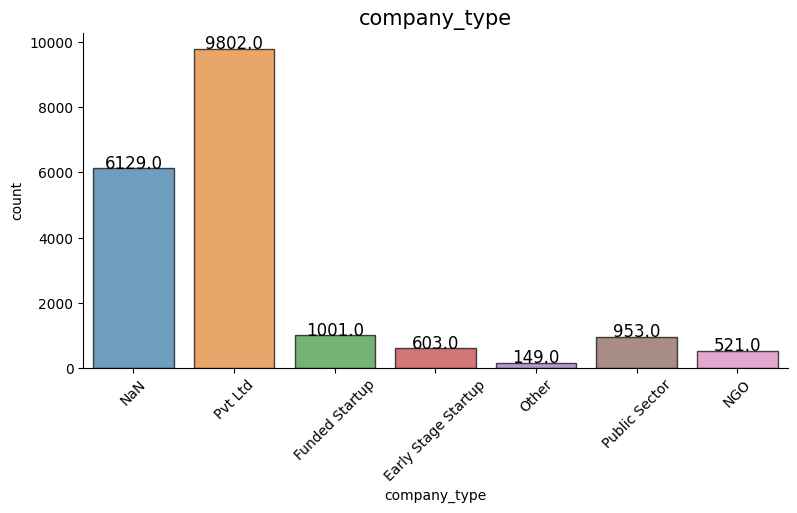

In [66]:
plt.figure(figsize = (20, 20))
column_list = ['company_type']
A = 0
for i in column_list:
    A+=1
    plt.subplot(4,2,A)
    ax = sns.countplot(data = new_df.fillna('NaN'), x = i, alpha = 0.7, edgecolor = 'black')
    sns.despine() 
    plt.title(i, fontsize = 15)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 12)
    if A >=0:
        plt.xticks(rotation = 45)

In [67]:
new_df['company_type'].value_counts(dropna = False)

Pvt Ltd                9802
NaN                    6129
Funded Startup         1001
Public Sector           953
Early Stage Startup     603
NGO                     521
Other                   149
Name: company_type, dtype: int64

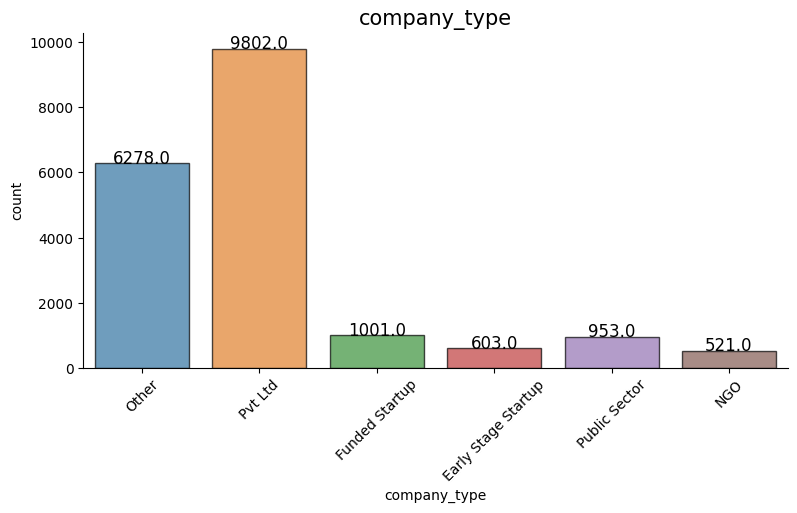

In [68]:
nan_index = new_df[(new_df['company_type'].isna())].index
new_df['company_type'][nan_index] = 'Other'

plt.figure(figsize = (20, 20))
column_list = ['company_type']
A = 0
for i in column_list:
    A+=1
    plt.subplot(4,2,A)
    ax = sns.countplot(data = new_df.fillna('NaN'), x = i, alpha = 0.7, edgecolor = 'black')
    sns.despine() 
    plt.title(i, fontsize = 15)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 12)
    if A >=0:
        plt.xticks(rotation = 45)

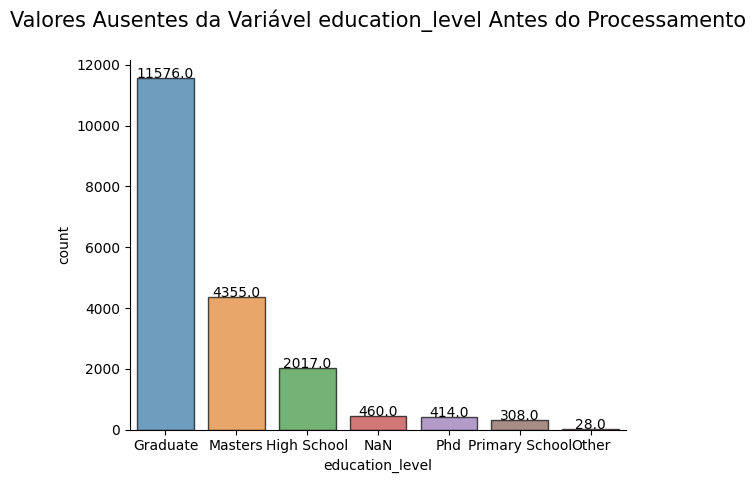

In [70]:
sns.countplot(data = new_df.fillna('NaN'), x = 'education_level', alpha = 0.7, edgecolor = 'black')
sns.despine()
plt.xticks()
bound=ax.get_xbound()
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 10)
plt.title("Valores Ausentes da Variável education_level Antes do Processamento\n", fontsize = 15)
plt.show()

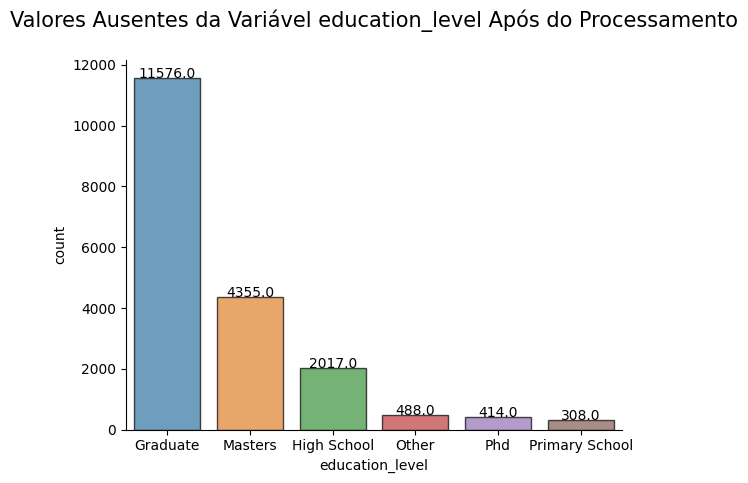

In [71]:
nan_index = new_df[(new_df['education_level'].isna())].index
new_df['education_level'][nan_index] = 'Other'

sns.countplot(data = new_df.fillna('NaN'), x = 'education_level', alpha = 0.7, edgecolor = 'black')
sns.despine()
plt.xticks()
bound=ax.get_xbound()
ax=plt.gca()
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha = 'center', color = 'black', size = 10)
plt.title("Valores Ausentes da Variável education_level Após do Processamento\n", fontsize = 15)
plt.show()

In [72]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   city_development_index  19158 non-null  object
 1   experience              19095 non-null  object
 2   enrolled_university     19158 non-null  object
 3   relevent_experience     19158 non-null  object
 4   education_level         19158 non-null  object
 5   company_type            19158 non-null  object
 6   major_discipline        19158 non-null  object
 7   target                  19158 non-null  object
dtypes: object(8)
memory usage: 1.2+ MB


In [73]:
new_df['experience'].value_counts(dropna = False)

>20      3281
5        1427
4        1402
3        1351
6        1214
2        1124
7        1028
10        982
9         980
8         802
15        685
11        664
14        586
1         549
<1        520
16        506
12        494
13        399
17        342
19        304
18        279
20        148
NaN        63
Other      28
Name: experience, dtype: int64

In [74]:
percent_missing = new_df.isnull().sum() / len(new_df) * 100 # Percentual de valores ausentes
percent_missing

city_development_index    0.000000
experience                0.328844
enrolled_university       0.000000
relevent_experience       0.000000
education_level           0.000000
company_type              0.000000
major_discipline          0.000000
target                    0.000000
dtype: float64

In [75]:
new_df['experience'].isnull().sum()

63

In [76]:
new_df = new_df.dropna()

In [77]:
percent_missing = new_df.isnull().sum() * 100 / len(new_df)
percent_missing

city_development_index    0.0
experience                0.0
enrolled_university       0.0
relevent_experience       0.0
education_level           0.0
company_type              0.0
major_discipline          0.0
target                    0.0
dtype: float64

In [79]:
new_df['enrolled_university'] = new_df['enrolled_university'].replace('no_enrollment', 'No enrollment')

In [80]:
x = new_df.drop(columns = ['target'])
y = new_df['target']